### 1. Load MCR forest Library

In [1]:
import mcrforest

In [2]:
from mcrforest.forest import RandomForestRegressor as MCRForestRegressor
print("✅ MCRForest loaded with correct NumPy & SciPy!")

✅ MCRForest loaded with correct NumPy & SciPy!


In [3]:
import pandas as pd

# Load the final datasets
ba_final = pd.read_csv("/home/lixsk81/workspace/BA_2New.csv")
em_final = pd.read_csv("/home/lixsk81/workspace/Emirates_1Newcsv")

# Quick sanity check
print("=== British Airways Final ===")
print(ba_final.shape)

print("\n=== Emirates Final ===")
print(em_final.shape)

=== British Airways Final ===
(3217, 46)

=== Emirates Final ===
(1475, 47)


In [4]:
# Drop distance_km from both datasets
ba_final = ba_final.drop(columns=["distance_km"])
em_final = em_final.drop(columns=["distance_km"])

### Assign to Pre,During & Post Covid Periods

In [5]:
import pandas as pd

# Convert review_date to datetime
ba_final["review_date"] = pd.to_datetime(ba_final["review_date"])
em_final["review_date"] = pd.to_datetime(em_final["review_date"])

# Function to tag covid period
def assign_covid_period(date):
    if date < pd.Timestamp("2020-01-01"):
        return "pre"
    elif pd.Timestamp("2020-01-01") <= date <= pd.Timestamp("2021-12-31"):
        return "during"
    else:
        return "post"

# Apply period labeling
ba_final["covid_period"] = ba_final["review_date"].apply(assign_covid_period)
em_final["covid_period"] = em_final["review_date"].apply(assign_covid_period)

# Split into separate dataframes
ba_pre = ba_final[ba_final["covid_period"] == "pre"]
ba_during = ba_final[ba_final["covid_period"] == "during"]
ba_post = ba_final[ba_final["covid_period"] == "post"]

em_pre = em_final[em_final["covid_period"] == "pre"]
em_during = em_final[em_final["covid_period"] == "during"]
em_post = em_final[em_final["covid_period"] == "post"]

# Quick sanity check
print("British Airways:", ba_pre.shape, ba_during.shape, ba_post.shape)
print("Emirates:", em_pre.shape, em_during.shape, em_post.shape)

British Airways: (2559, 46) (191, 46) (467, 46)
Emirates: (1080, 47) (153, 47) (242, 47)


## British Airways Pre,During & Post MCR analysis

Loaded the parameters from the Cross Validation Parameters from Predection_Star_Rating.ipynb notebook

In [6]:
from mcrforest.forest import RandomForestRegressor as MCRForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Custom function: run MCR using *already tuned params*
def run_mcr_period(df, airline, period_name, best_params, ):
    if df.empty:
        print(f"No data for {airline} {period_name}")
        return None, None, None, None

    # Drop target + leakage columns
    X = df.drop(columns=[ "overall_rating",     # target
    "review_date",        # timestamp
    "sentiment_score",    # redundant with aspect sentiments
    "optimism",'joy','anger',           # emotion overlap
    "sadness",            # emotion overlap
    "topic_qantas_related", 
    "topic_drinks_water", "recommended", "covid_period",'value_for_money'
    ])
    y = df["overall_rating"]
    X = X.select_dtypes(include=["int64", "float64"])

    print(f"\n=== {airline} | {period_name}-COVID (MCR) ===")

    # Fit tuned MCRForest
    mcr_model = MCRForestRegressor(**best_params)
    mcr_model.fit(X, y)

    # --- Plot MCR (avoid ax bug) ---
    mcr_df = mcr_model.plot_mcr(
        X, y,
        feature_names=X.columns,
        feature_groups_of_interest='all individual features',
        num_times=10,
        show_fig=True
    )


    return X, mcr_model, mcr_df


# ===========================
# Best Params from your RF runs
# ===========================

params_pre = {
    'n_estimators': 500,       # from your best CV result
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 30,
    'random_state': 42,
    'n_jobs': -1
}

params_during = {
    'n_estimators': 500,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 30,
    'random_state': 42,
    'n_jobs': -1
}

params_post = {
    'n_estimators': 300,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'max_depth': 30,
    'random_state': 42,
    'n_jobs': -1
}

### A] Model Class Reliance (MCR) – Pre-COVID Period

The code runs run_mcr_period on the Pre-period data to compute the feature matrix (X_pre), fit the MCR model (mcr_model_pre), and generate the MCR results DataFrame (mcr_df_pre).


=== BA | Pre-COVID (MCR) ===
Processing MCR+ groups of features.


100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


Processing MCR- groups of features.


100%|██████████| 29/29 [00:34<00:00,  1.17s/it]


MCR+ sum: 8.090311594873342


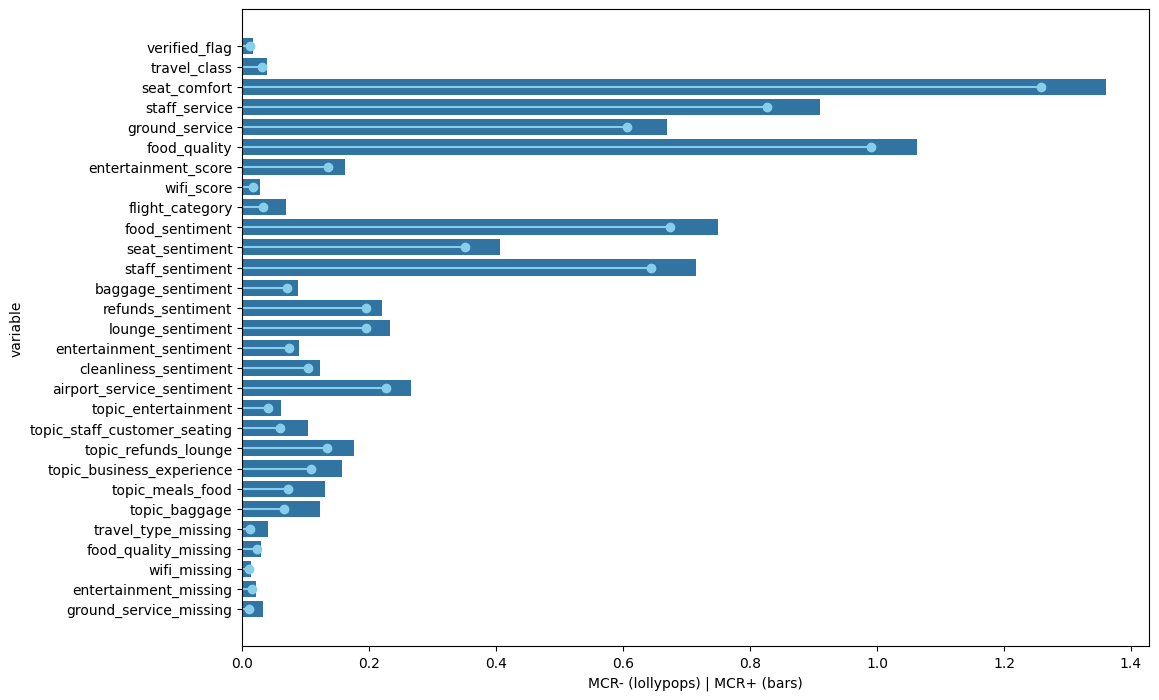

In [14]:
X_pre, mcr_model_pre, mcr_df_pre = run_mcr_period(ba_pre, "BA", "Pre", params_pre)

In [14]:
import os

# Define the path to your Downloads folder
download_path = r"C:\Users\Samiksha\Downloads\mcr_df_pre.csv"

# Save the DataFrame as CSV to Downloads
mcr_df_pre.to_csv(download_path, index=False)

print(f"CSV saved to: {download_path}")

CSV saved to: C:\Users\Samiksha\Downloads\mcr_df_pre.csv


In [22]:
import numpy as np
from scipy.stats import mode
X = ba_pre.drop(columns=[
       "overall_rating",     # target
    "review_date",        # timestamp
    "sentiment_score",    # redundant with aspect sentiments
    "optimism",'joy','anger',           # emotion overlap
    "sadness",            # emotion overlap
    "topic_qantas_related", 
    "topic_drinks_water", "recommended", "covid_period",'value_for_money'
    ])
y = ba_pre["overall_rating"]
X = X.select_dtypes(include=["int64", "float64"])
X_pred = mcr_model_pre.predict(X)

print(np.mean(abs(X_pred - y)))
print(np.mean(abs(X_pred - np.median(y))))

0.24291371769929124
2.601744308841261


- **SHAP-Based Feature Contributions (Positive Only) – Pre-COVID**

/home/lixsk81/.pyenv/versions/3.8.8/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/lixsk81/.pyenv/versions/3.8.8/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minim

 set_estimators(self, force_use = True, var_indexs = [0], debug = True )


100%|===================| 2552/2559 [06:05<00:01]        

 set_estimators(self, force_use = True, var_indexs = [1], debug = True )


100%|===================| 2552/2559 [06:01<00:00]        

 set_estimators(self, force_use = True, var_indexs = [2], debug = True )


100%|===================| 2558/2559 [06:05<00:00]        

 set_estimators(self, force_use = True, var_indexs = [3], debug = True )


100%|===================| 2552/2559 [06:02<00:00]        

 set_estimators(self, force_use = True, var_indexs = [4], debug = True )


100%|===================| 2554/2559 [06:05<00:00]        

 set_estimators(self, force_use = True, var_indexs = [5], debug = True )


100%|===================| 2553/2559 [06:06<00:00]        

 set_estimators(self, force_use = True, var_indexs = [6], debug = True )


100%|===================| 2554/2559 [06:04<00:00]        

 set_estimators(self, force_use = True, var_indexs = [7], debug = True )


100%|===================| 2552/2559 [06:03<00:00]        

 set_estimators(self, force_use = True, var_indexs = [8], debug = True )


100%|===================| 2553/2559 [06:04<00:00]        

 set_estimators(self, force_use = True, var_indexs = [9], debug = True )


100%|===================| 2554/2559 [06:01<00:00]        

 set_estimators(self, force_use = True, var_indexs = [10], debug = True )


100%|===================| 2555/2559 [06:23<00:00]        

 set_estimators(self, force_use = True, var_indexs = [11], debug = True )


100%|===================| 2558/2559 [06:02<00:00]        

 set_estimators(self, force_use = True, var_indexs = [12], debug = True )


100%|===================| 2558/2559 [06:04<00:00]        

 set_estimators(self, force_use = True, var_indexs = [13], debug = True )


100%|===================| 2555/2559 [06:04<00:00]        

 set_estimators(self, force_use = True, var_indexs = [14], debug = True )


100%|===================| 2556/2559 [06:28<00:00]        

 set_estimators(self, force_use = True, var_indexs = [15], debug = True )


100%|===================| 2558/2559 [06:09<00:00]        

 set_estimators(self, force_use = True, var_indexs = [16], debug = True )


100%|===================| 2552/2559 [06:03<00:00]        

 set_estimators(self, force_use = True, var_indexs = [17], debug = True )


100%|===================| 2552/2559 [06:05<00:01]        

 set_estimators(self, force_use = True, var_indexs = [18], debug = True )


100%|===================| 2558/2559 [06:06<00:00]        

 set_estimators(self, force_use = True, var_indexs = [19], debug = True )


100%|===================| 2551/2559 [06:06<00:01]        

 set_estimators(self, force_use = True, var_indexs = [20], debug = True )


100%|===================| 2557/2559 [06:03<00:00]        

 set_estimators(self, force_use = True, var_indexs = [21], debug = True )


100%|===================| 2554/2559 [06:09<00:00]        

 set_estimators(self, force_use = True, var_indexs = [22], debug = True )


100%|===================| 2556/2559 [06:06<00:00]        

 set_estimators(self, force_use = True, var_indexs = [23], debug = True )


100%|===================| 2552/2559 [06:00<00:00]        

 set_estimators(self, force_use = True, var_indexs = [24], debug = True )


100%|===================| 2556/2559 [06:21<00:00]        

 set_estimators(self, force_use = True, var_indexs = [25], debug = True )


100%|===================| 2555/2559 [06:05<00:00]        

 set_estimators(self, force_use = True, var_indexs = [26], debug = True )


100%|===================| 2554/2559 [06:10<00:00]        

 set_estimators(self, force_use = True, var_indexs = [27], debug = True )


100%|===================| 2555/2559 [06:04<00:00]        

 set_estimators(self, force_use = True, var_indexs = [28], debug = True )


100%|===================| 2556/2559 [06:04<00:00]        

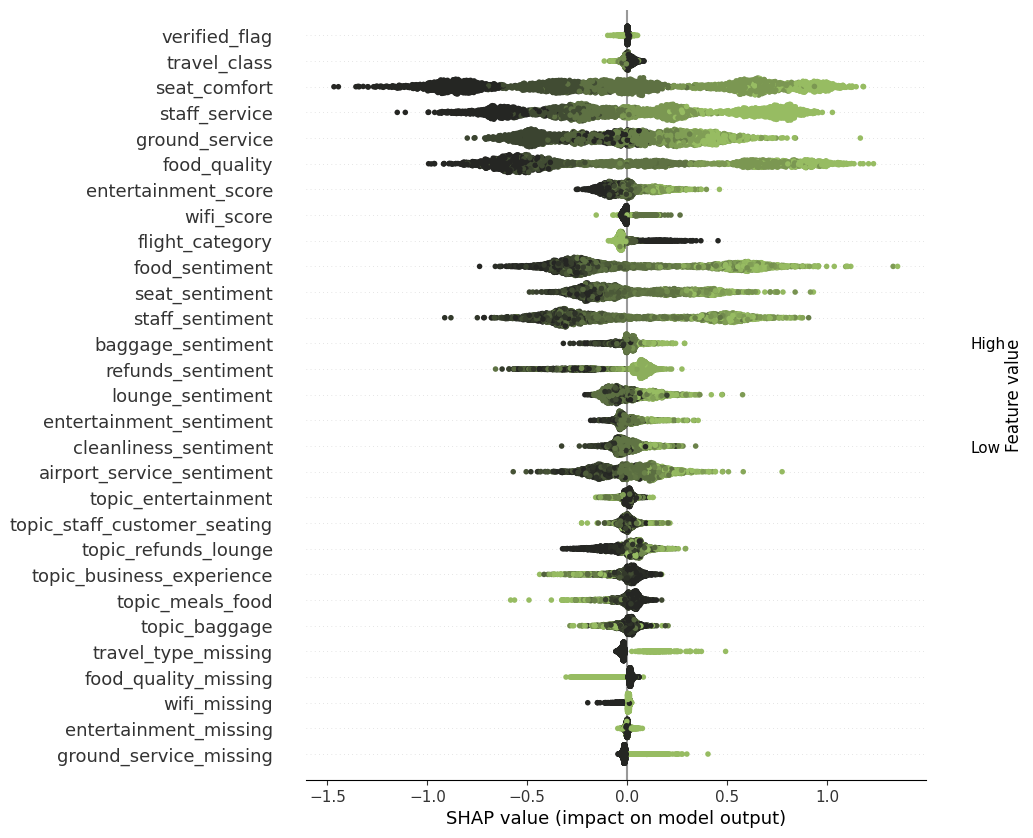

In [8]:
shap_plus_pre = mcr_model_pre.mcr_shap_plot(X_pre, mcr_plus=True, plot_size=(10,10), sort=False)

- **SHAP-Based Feature Contributions (Negative Only) – Pre-COVID**

/home/lixsk81/.pyenv/versions/3.8.8/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/lixsk81/.pyenv/versions/3.8.8/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minim

 set_estimators(self, force_use = False, var_indexs = [0], debug = True )


100%|===================| 2553/2559 [06:09<00:00]        

 set_estimators(self, force_use = False, var_indexs = [1], debug = True )


100%|===================| 2558/2559 [06:01<00:00]        

 set_estimators(self, force_use = False, var_indexs = [2], debug = True )


100%|===================| 2557/2559 [06:01<00:00]        

 set_estimators(self, force_use = False, var_indexs = [3], debug = True )


100%|===================| 2558/2559 [06:05<00:00]        

 set_estimators(self, force_use = False, var_indexs = [4], debug = True )


100%|===================| 2555/2559 [06:00<00:00]        

 set_estimators(self, force_use = False, var_indexs = [5], debug = True )


100%|===================| 2554/2559 [06:01<00:00]        

 set_estimators(self, force_use = False, var_indexs = [6], debug = True )


100%|===================| 2553/2559 [06:02<00:00]        

 set_estimators(self, force_use = False, var_indexs = [7], debug = True )


100%|===================| 2553/2559 [06:01<00:00]        

 set_estimators(self, force_use = False, var_indexs = [8], debug = True )


100%|===================| 2557/2559 [06:21<00:00]        

 set_estimators(self, force_use = False, var_indexs = [9], debug = True )


100%|===================| 2552/2559 [06:29<00:01]        

 set_estimators(self, force_use = False, var_indexs = [10], debug = True )


100%|===================| 2558/2559 [06:20<00:00]        

 set_estimators(self, force_use = False, var_indexs = [11], debug = True )


100%|===================| 2557/2559 [06:23<00:00]        

 set_estimators(self, force_use = False, var_indexs = [12], debug = True )


100%|===================| 2555/2559 [06:22<00:00]        

 set_estimators(self, force_use = False, var_indexs = [13], debug = True )


100%|===================| 2556/2559 [06:23<00:00]        

 set_estimators(self, force_use = False, var_indexs = [14], debug = True )


100%|===================| 2553/2559 [06:36<00:00]        

 set_estimators(self, force_use = False, var_indexs = [15], debug = True )


100%|===================| 2552/2559 [06:39<00:01]        

 set_estimators(self, force_use = False, var_indexs = [16], debug = True )


100%|===================| 2558/2559 [06:22<00:00]        

 set_estimators(self, force_use = False, var_indexs = [17], debug = True )


100%|===================| 2554/2559 [06:21<00:00]        

 set_estimators(self, force_use = False, var_indexs = [18], debug = True )


100%|===================| 2556/2559 [06:23<00:00]        

 set_estimators(self, force_use = False, var_indexs = [19], debug = True )


100%|===================| 2555/2559 [06:28<00:00]        

 set_estimators(self, force_use = False, var_indexs = [20], debug = True )


100%|===================| 2556/2559 [06:23<00:00]        

 set_estimators(self, force_use = False, var_indexs = [21], debug = True )


100%|===================| 2555/2559 [06:22<00:00]        

 set_estimators(self, force_use = False, var_indexs = [22], debug = True )


100%|===================| 2554/2559 [06:21<00:00]        

 set_estimators(self, force_use = False, var_indexs = [23], debug = True )


100%|===================| 2557/2559 [06:47<00:00]        

 set_estimators(self, force_use = False, var_indexs = [24], debug = True )


100%|===================| 2553/2559 [06:31<00:00]        

 set_estimators(self, force_use = False, var_indexs = [25], debug = True )


100%|===================| 2554/2559 [06:23<00:00]        

 set_estimators(self, force_use = False, var_indexs = [26], debug = True )


100%|===================| 2557/2559 [06:21<00:00]        

 set_estimators(self, force_use = False, var_indexs = [27], debug = True )


100%|===================| 2557/2559 [06:24<00:00]        

 set_estimators(self, force_use = False, var_indexs = [28], debug = True )


100%|===================| 2552/2559 [06:21<00:01]        

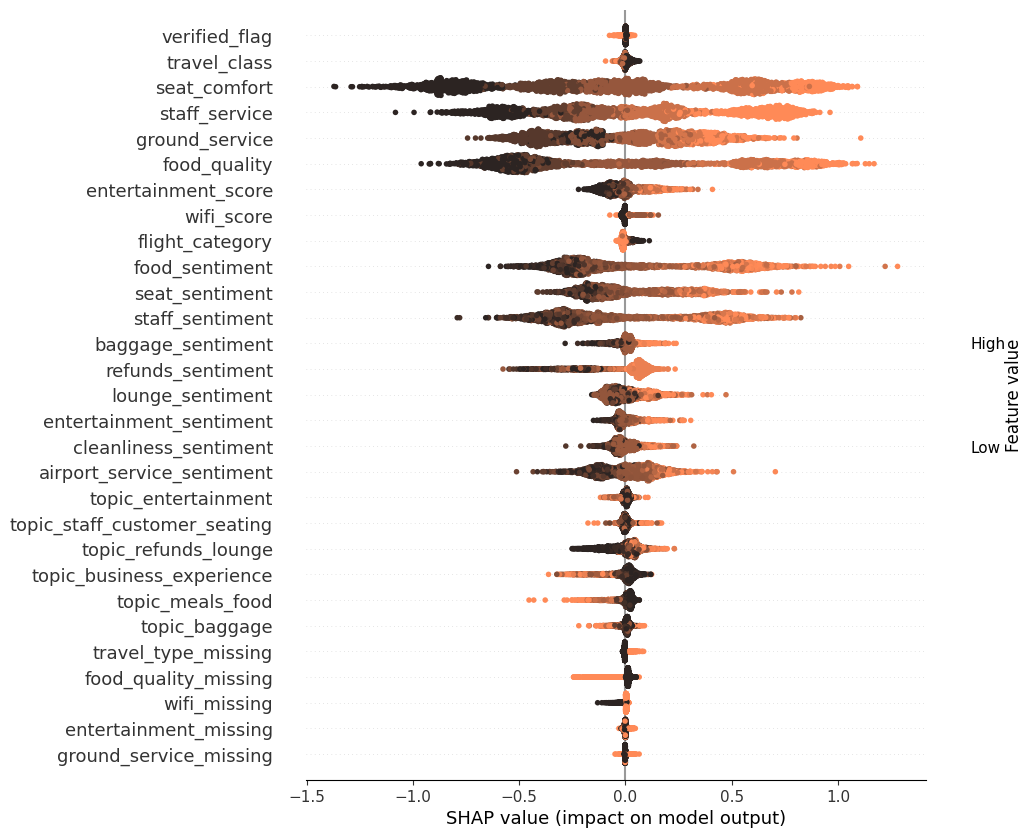

In [15]:
shap_minus_pre = mcr_model_pre.mcr_shap_plot(X_pre, mcr_plus=False, plot_size=(10,10), sort=False)

### A] Model Class Reliance (MCR) – During-COVID Period


=== BA | Pre-COVID (MCR) ===
Processing MCR+ groups of features.


100%|██████████| 29/29 [00:14<00:00,  2.01it/s]


Processing MCR- groups of features.


100%|██████████| 29/29 [00:16<00:00,  1.72it/s]


MCR+ sum: 8.628593098383194


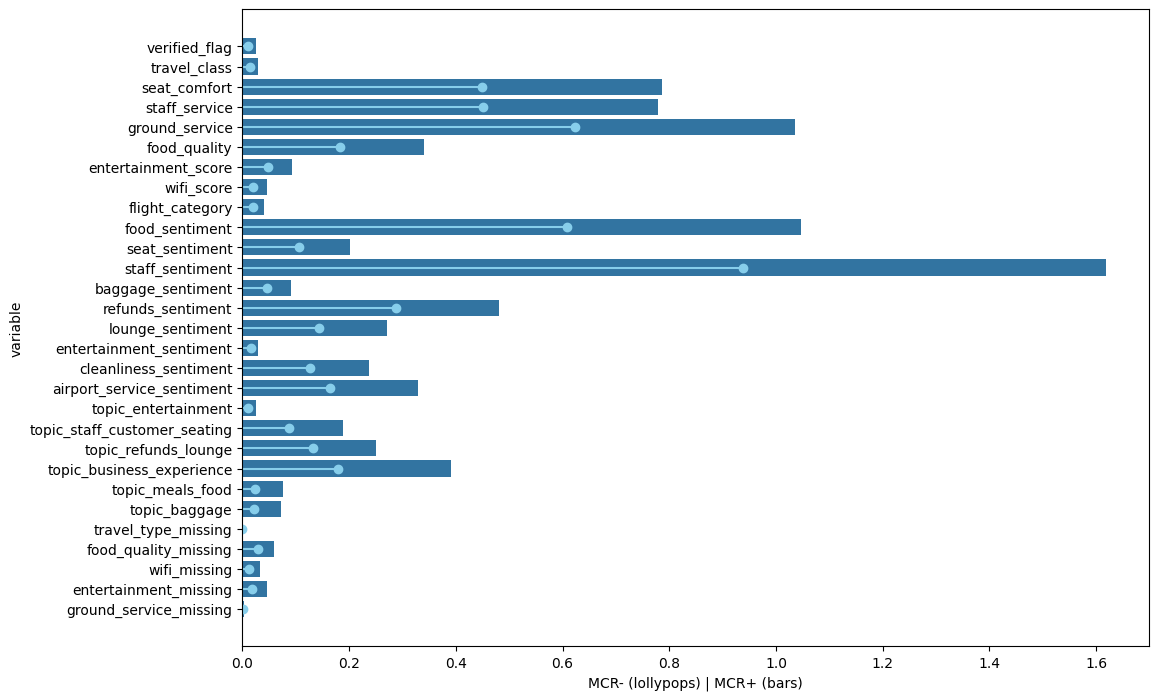

In [7]:
X_during, mcr_model_during, mcr_df_during = run_mcr_period(ba_during, "BA", "Pre", params_during)

In [16]:
import os

# Define the path to your Downloads folder
download_path = r"C:\Users\Samiksha\Downloads\mcr_df_during.csv"

# Save the DataFrame as CSV to Downloads
mcr_df_during.to_csv(download_path, index=False)

print(f"CSV saved to: {download_path}")

CSV saved to: C:\Users\Samiksha\Downloads\mcr_df_during.csv


- **SHAP-Based Feature Contributions (Positive Only) – During-COVID**

/home/lixsk81/.pyenv/versions/3.8.8/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/lixsk81/.pyenv/versions/3.8.8/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minim

 set_estimators(self, force_use = True, var_indexs = [0], debug = True )
 set_estimators(self, force_use = True, var_indexs = [1], debug = True )
 set_estimators(self, force_use = True, var_indexs = [2], debug = True )
 set_estimators(self, force_use = True, var_indexs = [3], debug = True )
 set_estimators(self, force_use = True, var_indexs = [4], debug = True )
 set_estimators(self, force_use = True, var_indexs = [5], debug = True )
 set_estimators(self, force_use = True, var_indexs = [6], debug = True )
 set_estimators(self, force_use = True, var_indexs = [7], debug = True )
 set_estimators(self, force_use = True, var_indexs = [8], debug = True )
 set_estimators(self, force_use = True, var_indexs = [9], debug = True )
 set_estimators(self, force_use = True, var_indexs = [10], debug = True )
 set_estimators(self, force_use = True, var_indexs = [11], debug = True )
 set_estimators(self, force_use = True, var_indexs = [12], debug = True )
 set_estimators(self, force_use = True, var_inde

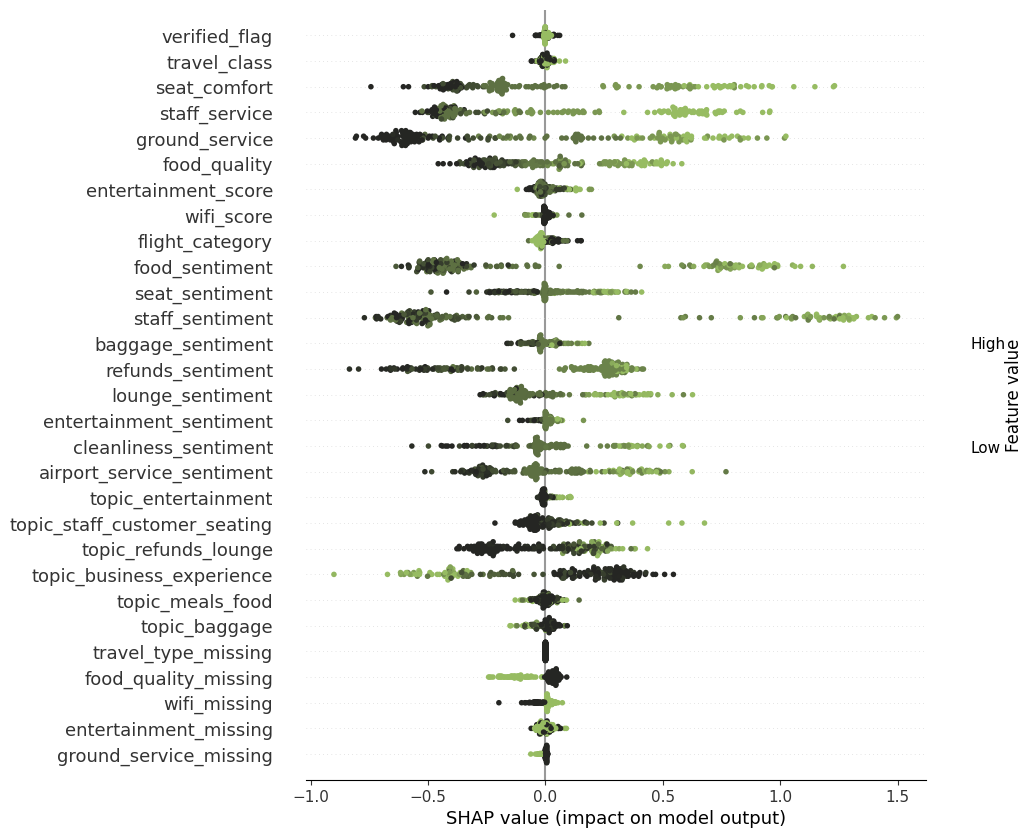

In [8]:
shap_plus_during = mcr_model_during.mcr_shap_plot(X_during, mcr_plus=True, plot_size=(10,10), sort=False)

- **SHAP-Based Feature Contributions (Negative Only) – During-COVID**

 set_estimators(self, force_use = False, var_indexs = [0], debug = True )
 set_estimators(self, force_use = False, var_indexs = [1], debug = True )
 set_estimators(self, force_use = False, var_indexs = [2], debug = True )
 set_estimators(self, force_use = False, var_indexs = [3], debug = True )
 set_estimators(self, force_use = False, var_indexs = [4], debug = True )
 set_estimators(self, force_use = False, var_indexs = [5], debug = True )
 set_estimators(self, force_use = False, var_indexs = [6], debug = True )
 set_estimators(self, force_use = False, var_indexs = [7], debug = True )
 set_estimators(self, force_use = False, var_indexs = [8], debug = True )
 set_estimators(self, force_use = False, var_indexs = [9], debug = True )
 set_estimators(self, force_use = False, var_indexs = [10], debug = True )
 set_estimators(self, force_use = False, var_indexs = [11], debug = True )
 set_estimators(self, force_use = False, var_indexs = [12], debug = True )
 set_estimators(self, force_use = F

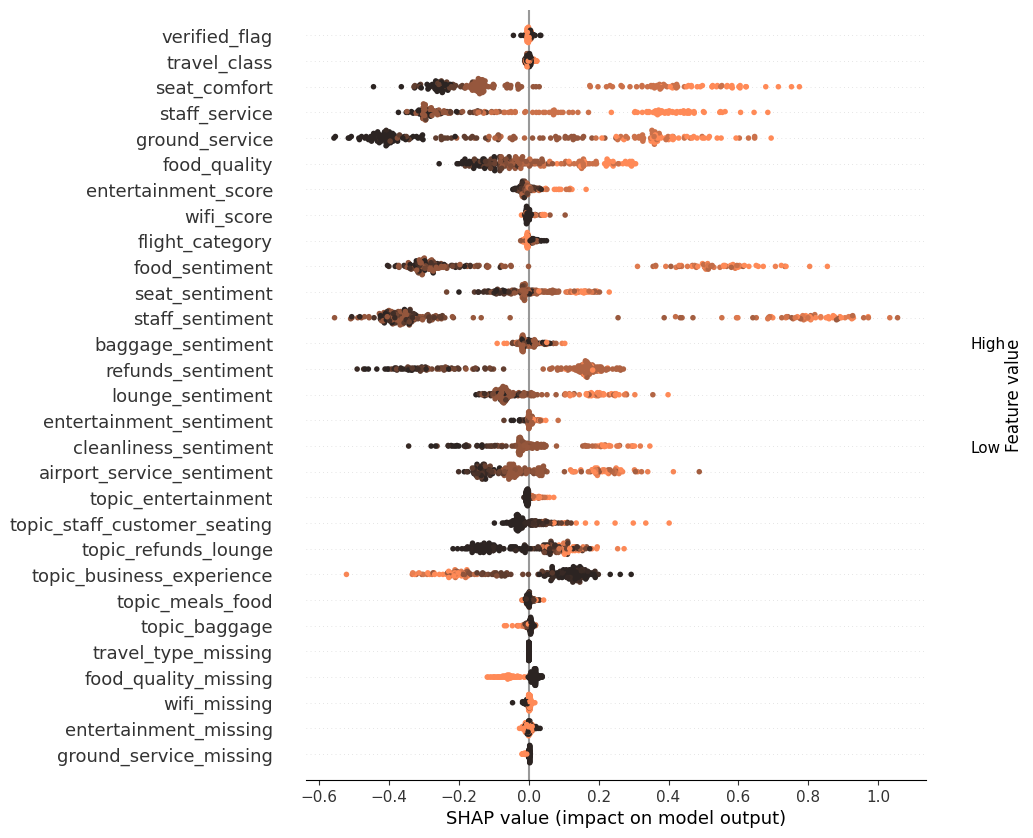

In [9]:
shap_minus_during = mcr_model_during.mcr_shap_plot(X_during, mcr_plus=False, plot_size=(10,10), sort=False)

### A] Model Class Reliance (MCR) – Post-COVID Period


=== BA | Pre-COVID (MCR) ===


Processing MCR+ groups of features.


100%|██████████| 29/29 [00:13<00:00,  2.16it/s]


Processing MCR- groups of features.


100%|██████████| 29/29 [00:13<00:00,  2.16it/s]


MCR+ sum: 128.3770877944325


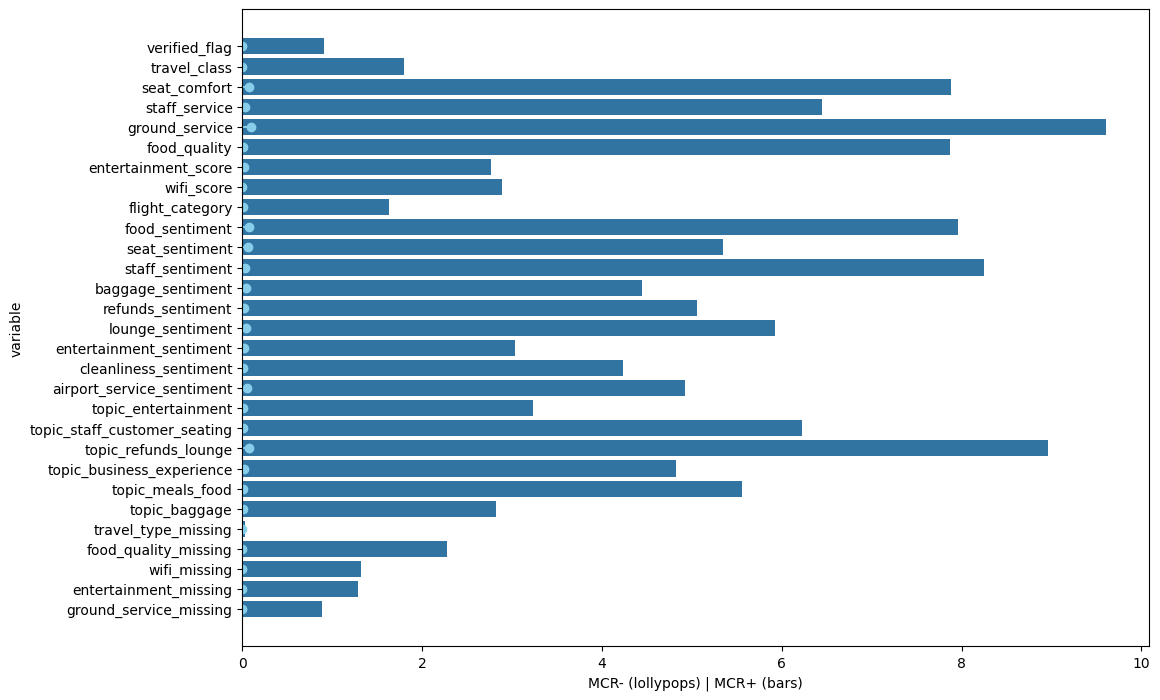

In [17]:
X_post, mcr_model_post, mcr_df_post = run_mcr_period(ba_post, "BA", "Pre", params_post)

In [18]:
import os

# Define the path to your Downloads folder
download_path = r"C:\Users\Samiksha\Downloads\mcr_df_post.csv"

# Save the DataFrame as CSV to Downloads
mcr_df_post.to_csv(download_path, index=False)

print(f"CSV saved to: {download_path}")

CSV saved to: C:\Users\Samiksha\Downloads\mcr_df_post.csv


- **SHAP-Based Feature Contributions (Positive Only) – Post-COVID**

/home/lixsk81/.pyenv/versions/3.8.8/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/lixsk81/.pyenv/versions/3.8.8/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minim

 set_estimators(self, force_use = True, var_indexs = [0], debug = True )
 set_estimators(self, force_use = True, var_indexs = [1], debug = True )
 set_estimators(self, force_use = True, var_indexs = [2], debug = True )
 set_estimators(self, force_use = True, var_indexs = [3], debug = True )
 set_estimators(self, force_use = True, var_indexs = [4], debug = True )
 set_estimators(self, force_use = True, var_indexs = [5], debug = True )
 set_estimators(self, force_use = True, var_indexs = [6], debug = True )
 set_estimators(self, force_use = True, var_indexs = [7], debug = True )
 set_estimators(self, force_use = True, var_indexs = [8], debug = True )
 set_estimators(self, force_use = True, var_indexs = [9], debug = True )
 set_estimators(self, force_use = True, var_indexs = [10], debug = True )
 set_estimators(self, force_use = True, var_indexs = [11], debug = True )
 set_estimators(self, force_use = True, var_indexs = [12], debug = True )
 set_estimators(self, force_use = True, var_inde

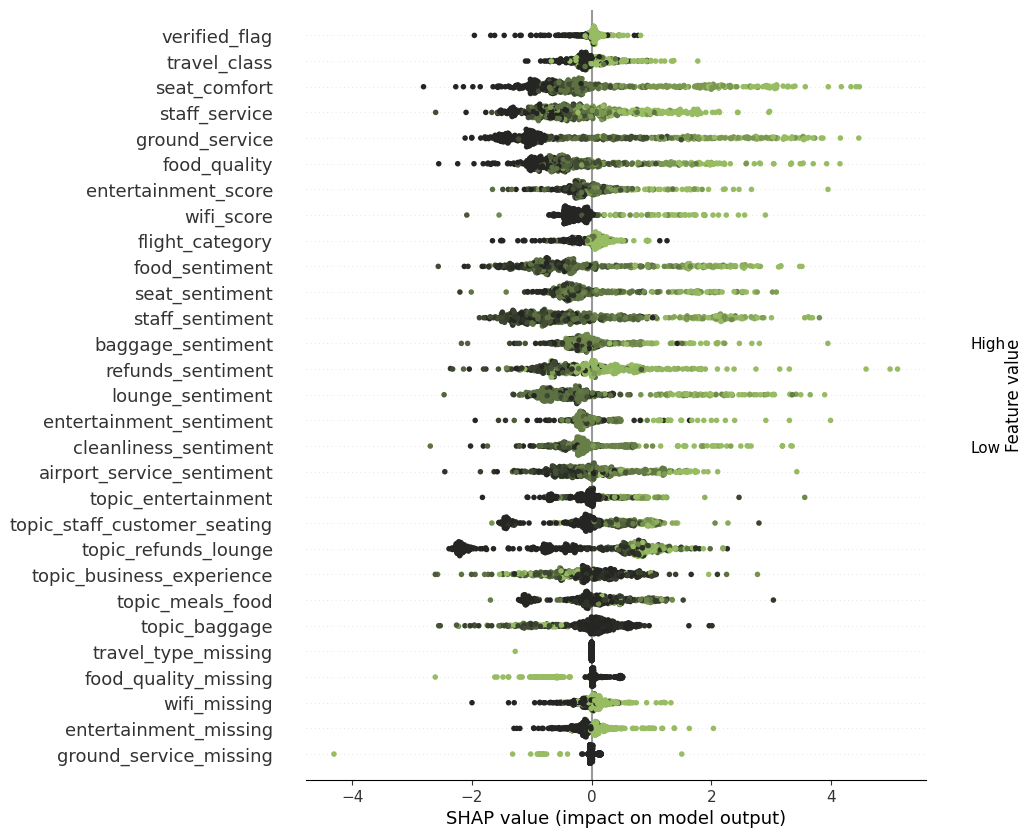

In [19]:
shap_plus_post = mcr_model_post.mcr_shap_plot(X_post, mcr_plus=True, plot_size=(10,10), sort=False)

- **SHAP-Based Feature Contributions (Negative Only) – Post-COVID**

 set_estimators(self, force_use = False, var_indexs = [0], debug = True )


 set_estimators(self, force_use = False, var_indexs = [1], debug = True )
 set_estimators(self, force_use = False, var_indexs = [2], debug = True )
 set_estimators(self, force_use = False, var_indexs = [3], debug = True )
 set_estimators(self, force_use = False, var_indexs = [4], debug = True )
 set_estimators(self, force_use = False, var_indexs = [5], debug = True )
 set_estimators(self, force_use = False, var_indexs = [6], debug = True )
 set_estimators(self, force_use = False, var_indexs = [7], debug = True )
 set_estimators(self, force_use = False, var_indexs = [8], debug = True )
 set_estimators(self, force_use = False, var_indexs = [9], debug = True )
 set_estimators(self, force_use = False, var_indexs = [10], debug = True )
 set_estimators(self, force_use = False, var_indexs = [11], debug = True )
 set_estimators(self, force_use = False, var_indexs = [12], debug = True )
 set_estimators(self, force_use = False, var_indexs = [13], debug = True )
 set_estimators(self, force_use = 

100%|===================| 465/467 [00:20<00:00]        

 set_estimators(self, force_use = False, var_indexs = [25], debug = True )


 96%|=================== | 448/467 [00:12<00:00]       

 set_estimators(self, force_use = False, var_indexs = [26], debug = True )
 set_estimators(self, force_use = False, var_indexs = [27], debug = True )
 set_estimators(self, force_use = False, var_indexs = [28], debug = True )


 95%|=================== | 445/467 [00:18<00:00]       

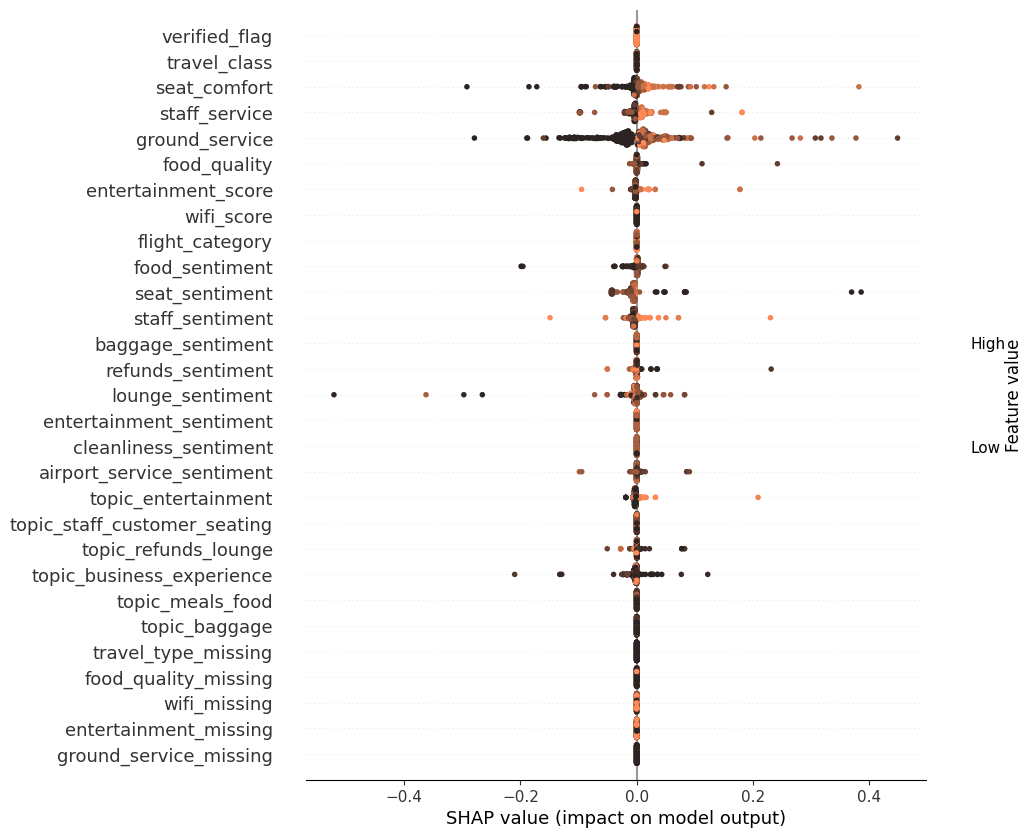

In [20]:
shap_minus_post = mcr_model_post.mcr_shap_plot(X_post, mcr_plus=False, plot_size=(10,10), sort=False)

# Emirates Pre,During & Post MCR analysis

In [7]:
# ===========================
# Emirates Best Params (define first!)
# ===========================
em_params_pre = {
    "n_estimators": 300,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "max_depth": 10
}

em_params_during = {
    "n_estimators": 300,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": "log2",
    "max_depth": 30
}

em_params_post = {
    "n_estimators": 300,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": "log2",
    "max_depth": 30
}


## A] Model Class Reliance (MCR) – Pre-COVID Period


=== Emirates | Pre-COVID (MCR) ===


Processing MCR+ groups of features.


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Processing MCR- groups of features.


100%|██████████| 29/29 [01:00<00:00,  2.08s/it]


MCR+ sum: 6.70117765884664


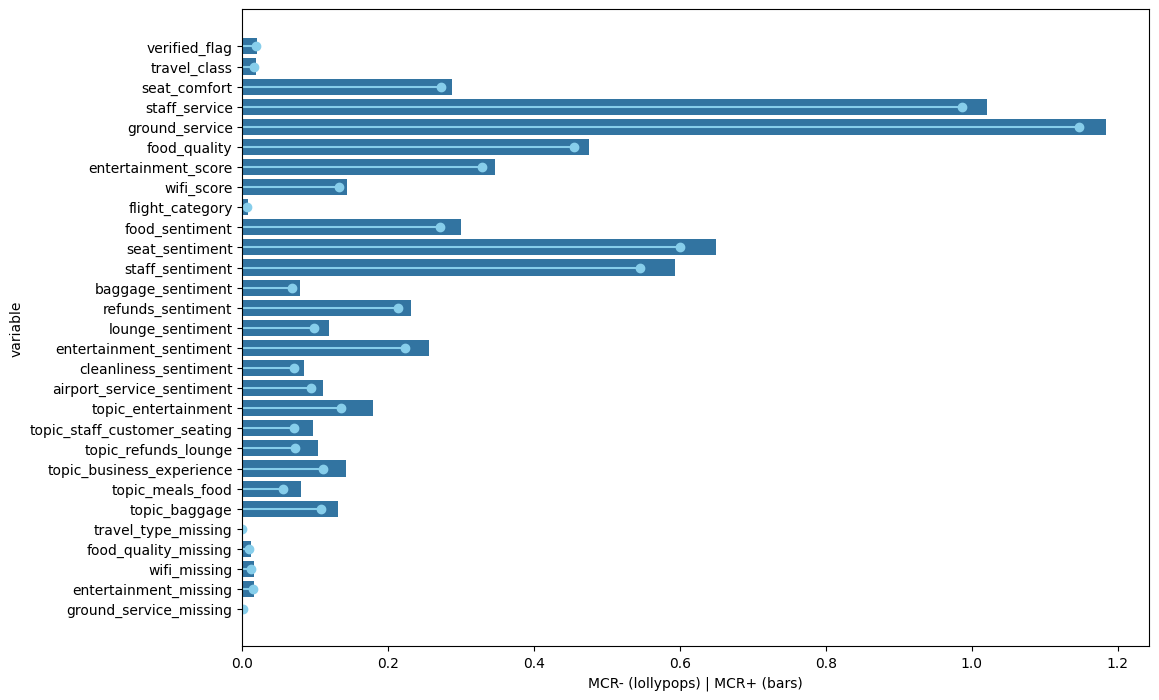

In [8]:
X_em_pre, mcr_model_em_pre, mcr_df_em_pre = run_mcr_period(em_pre, "Emirates", "Pre", em_params_pre)

In [9]:
import os

# Define the path to your Downloads folder
download_path = r"C:\Users\Samiksha\Downloads\mcr_df_em_pre"

# Save the DataFrame as CSV to Downloads
mcr_df_em_pre.to_csv(download_path, index=False)

print(f"CSV saved to: {download_path}")

CSV saved to: C:\Users\Samiksha\Downloads\mcr_df_em_pre


In [50]:
import numpy as np

# --- Emirates Pre-COVID ---
X_em = em_pre.drop(columns=[
    "overall_rating", "review_date", "recommended", "covid_period",
    "value_for_money", "sentiment_score"
])
y_em = em_pre["overall_rating"]
X_em = X_em.select_dtypes(include=["int64", "float64"])

X_em_pred = mcr_model_em_pre.predict(X_em)

print("=== Emirates Pre-COVID ===")
print("MAE vs actual:", np.mean(abs(X_em_pred - y_em)))
print("MAE vs median baseline:", np.mean(abs(X_em_pred - np.median(y_em))))


=== Emirates Pre-COVID ===
MAE vs actual: 0.7059285162468367
MAE vs median baseline: 2.583101738451956


- **SHAP-Based Feature Contributions (Positive Only) – Pre-COVID (MCRForest Model)**

 set_estimators(self, force_use = True, var_indexs = [0], debug = True )


 98%|===================| 1063/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [1], debug = True )


 99%|===================| 1067/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [2], debug = True )


100%|===================| 1077/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [3], debug = True )


 98%|===================| 1063/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [4], debug = True )


100%|===================| 1076/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [5], debug = True )


 98%|===================| 1061/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [6], debug = True )


100%|===================| 1075/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [7], debug = True )


 98%|===================| 1060/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [8], debug = True )


 99%|===================| 1069/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [9], debug = True )


100%|===================| 1079/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [10], debug = True )


 99%|===================| 1066/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [11], debug = True )


100%|===================| 1079/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [12], debug = True )


 99%|===================| 1064/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [13], debug = True )


100%|===================| 1077/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [14], debug = True )


 99%|===================| 1064/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [15], debug = True )


 99%|===================| 1074/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [16], debug = True )


 98%|===================| 1055/1080 [00:43<00:01]        

 set_estimators(self, force_use = True, var_indexs = [17], debug = True )


 98%|===================| 1062/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [18], debug = True )


100%|===================| 1076/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [19], debug = True )


 98%|===================| 1058/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [20], debug = True )


 99%|===================| 1071/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [21], debug = True )


 98%|===================| 1056/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [22], debug = True )


 99%|===================| 1068/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [23], debug = True )


100%|===================| 1075/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [24], debug = True )


 98%|===================| 1061/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [25], debug = True )


 99%|===================| 1073/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [26], debug = True )


100%|===================| 1078/1080 [00:44<00:00]        

 set_estimators(self, force_use = True, var_indexs = [27], debug = True )


 98%|===================| 1057/1080 [00:43<00:00]        

 set_estimators(self, force_use = True, var_indexs = [28], debug = True )


 99%|===================| 1069/1080 [00:43<00:00]        

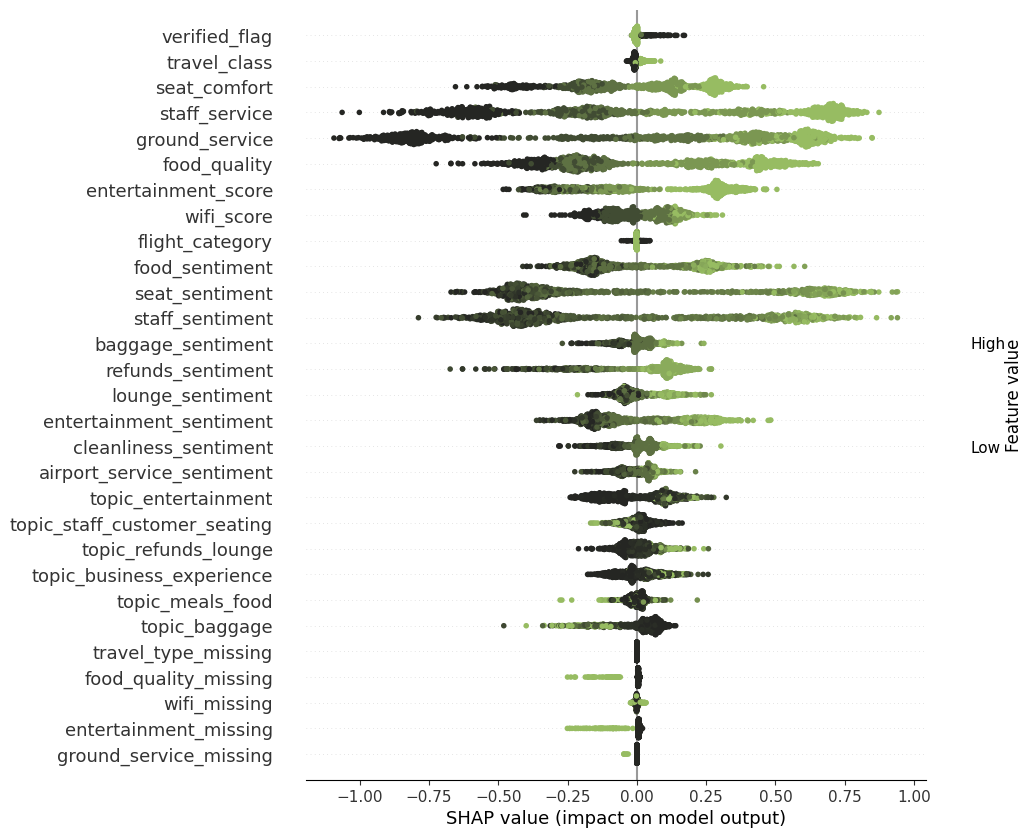

In [18]:
shap_plus_em_pre = mcr_model_em_pre.mcr_shap_plot(X_em_pre, mcr_plus=True, plot_size=(10,10), sort=False)

- **SHAP-Based Feature Contributions (Negative Only) – Pre-COVID (MCRForest Model)**

 set_estimators(self, force_use = False, var_indexs = [0], debug = True )


 99%|===================| 1066/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [1], debug = True )


 49%|==========          | 534/1080 [00:22<00:22]       

100%|===================| 1076/1080 [00:44<00:00]        

 set_estimators(self, force_use = False, var_indexs = [2], debug = True )


 98%|===================| 1058/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [3], debug = True )


 99%|===================| 1067/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [4], debug = True )


100%|===================| 1079/1080 [00:44<00:00]        

 set_estimators(self, force_use = False, var_indexs = [5], debug = True )


 98%|===================| 1063/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [6], debug = True )


100%|===================| 1075/1080 [00:44<00:00]        

 set_estimators(self, force_use = False, var_indexs = [7], debug = True )


 98%|===================| 1061/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [8], debug = True )


 99%|===================| 1073/1080 [00:44<00:00]        

 set_estimators(self, force_use = False, var_indexs = [9], debug = True )


 98%|===================| 1055/1080 [00:43<00:01]        

 set_estimators(self, force_use = False, var_indexs = [10], debug = True )


 99%|===================| 1065/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [11], debug = True )


100%|===================| 1077/1080 [00:44<00:00]        

 set_estimators(self, force_use = False, var_indexs = [12], debug = True )


 99%|===================| 1065/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [13], debug = True )


100%|===================| 1077/1080 [00:44<00:00]        

 set_estimators(self, force_use = False, var_indexs = [14], debug = True )


 98%|===================| 1063/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [15], debug = True )


100%|===================| 1075/1080 [00:44<00:00]        

 set_estimators(self, force_use = False, var_indexs = [16], debug = True )


 98%|===================| 1062/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [17], debug = True )


100%|===================| 1076/1080 [00:44<00:00]        

 set_estimators(self, force_use = False, var_indexs = [18], debug = True )


 99%|===================| 1064/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [19], debug = True )


100%|===================| 1075/1080 [00:44<00:00]        

 set_estimators(self, force_use = False, var_indexs = [20], debug = True )


 99%|===================| 1064/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [21], debug = True )


 99%|===================| 1074/1080 [00:44<00:00]        

 set_estimators(self, force_use = False, var_indexs = [22], debug = True )


 98%|===================| 1055/1080 [00:43<00:01]        

 set_estimators(self, force_use = False, var_indexs = [23], debug = True )


 99%|===================| 1069/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [24], debug = True )


 98%|===================| 1057/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [25], debug = True )


 99%|===================| 1069/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [26], debug = True )


 98%|===================| 1055/1080 [00:43<00:01]        

 set_estimators(self, force_use = False, var_indexs = [27], debug = True )


 99%|===================| 1066/1080 [00:43<00:00]        

 set_estimators(self, force_use = False, var_indexs = [28], debug = True )


 99%|===================| 1073/1080 [00:44<00:00]        

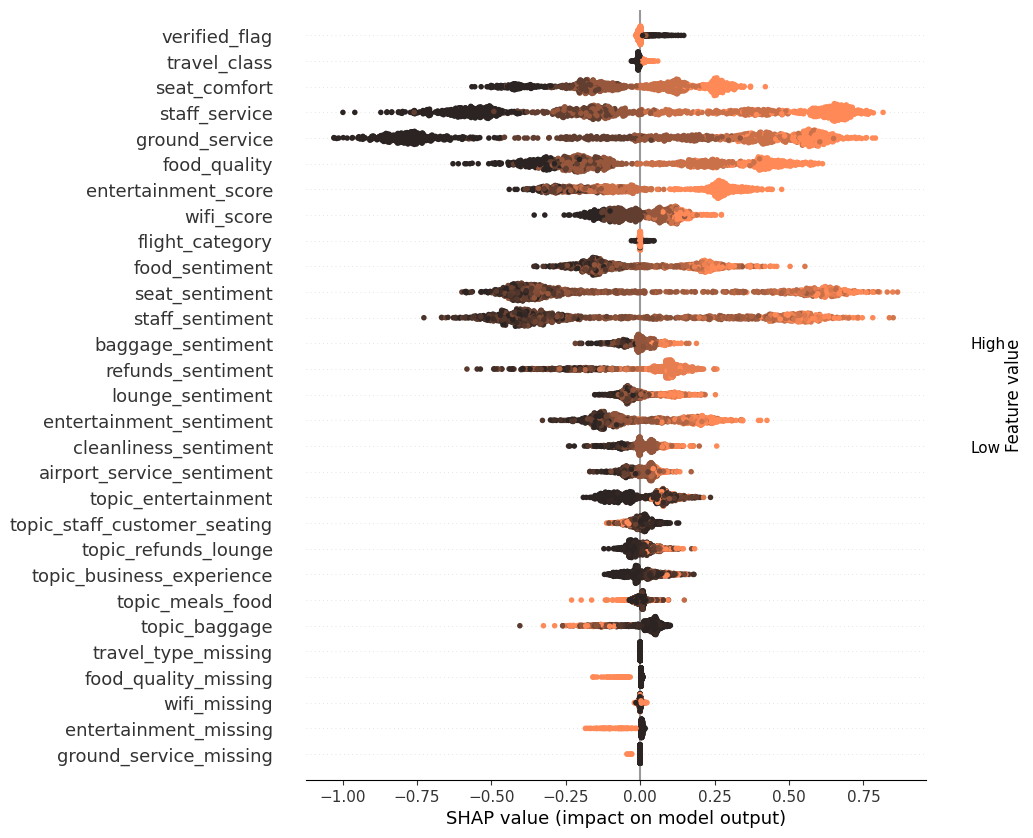

In [19]:
shap_minus_em_pre = mcr_model_em_pre.mcr_shap_plot(X_em_pre, mcr_plus=False, plot_size=(10,10), sort=False)

### A] Model Class Reliance (MCR) – During-COVID Period

- **SHAP-Based Feature Contributions (MCR+) – During-COVID**


=== Emirates | During-COVID (MCR) ===


Processing MCR+ groups of features.


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


Processing MCR- groups of features.


100%|██████████| 29/29 [00:10<00:00,  2.88it/s]


MCR+ sum: 200.1481710312273


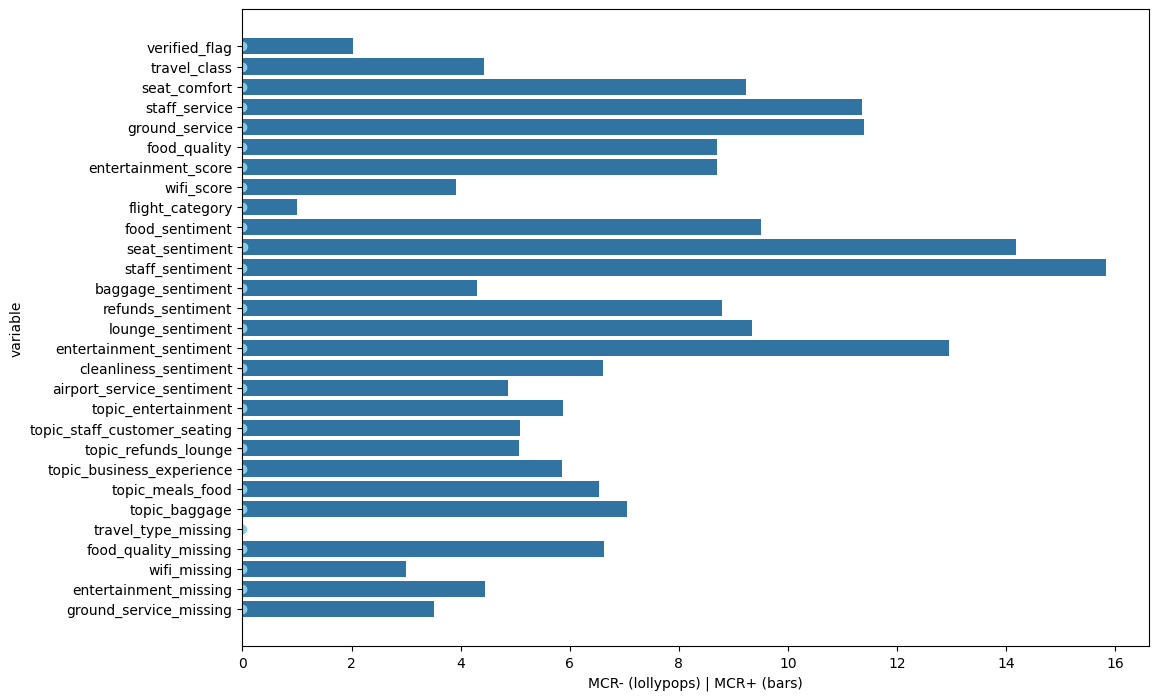

In [10]:
X_em_during, mcr_model_em_during, mcr_df_em_during = run_mcr_period(em_during, "Emirates", "During", em_params_during)

In [11]:
import os

# Define the path to your Downloads folder
download_path = r"C:\Users\Samiksha\Downloads\mcr_df_em_during"

# Save the DataFrame as CSV to Downloads
mcr_df_em_during.to_csv(download_path, index=False)

print(f"CSV saved to: {download_path}")

CSV saved to: C:\Users\Samiksha\Downloads\mcr_df_em_during


- **SHAP-Based Feature Contributions (Positive Only) – During-COVID (MCRForest Model)**

 set_estimators(self, force_use = True, var_indexs = [0], debug = True )
 set_estimators(self, force_use = True, var_indexs = [1], debug = True )
 set_estimators(self, force_use = True, var_indexs = [2], debug = True )
 set_estimators(self, force_use = True, var_indexs = [3], debug = True )
 set_estimators(self, force_use = True, var_indexs = [4], debug = True )
 set_estimators(self, force_use = True, var_indexs = [5], debug = True )
 set_estimators(self, force_use = True, var_indexs = [6], debug = True )
 set_estimators(self, force_use = True, var_indexs = [7], debug = True )
 set_estimators(self, force_use = True, var_indexs = [8], debug = True )
 set_estimators(self, force_use = True, var_indexs = [9], debug = True )
 set_estimators(self, force_use = True, var_indexs = [10], debug = True )
 set_estimators(self, force_use = True, var_indexs = [11], debug = True )
 set_estimators(self, force_use = True, var_indexs = [12], debug = True )
 set_estimators(self, force_use = True, var_inde

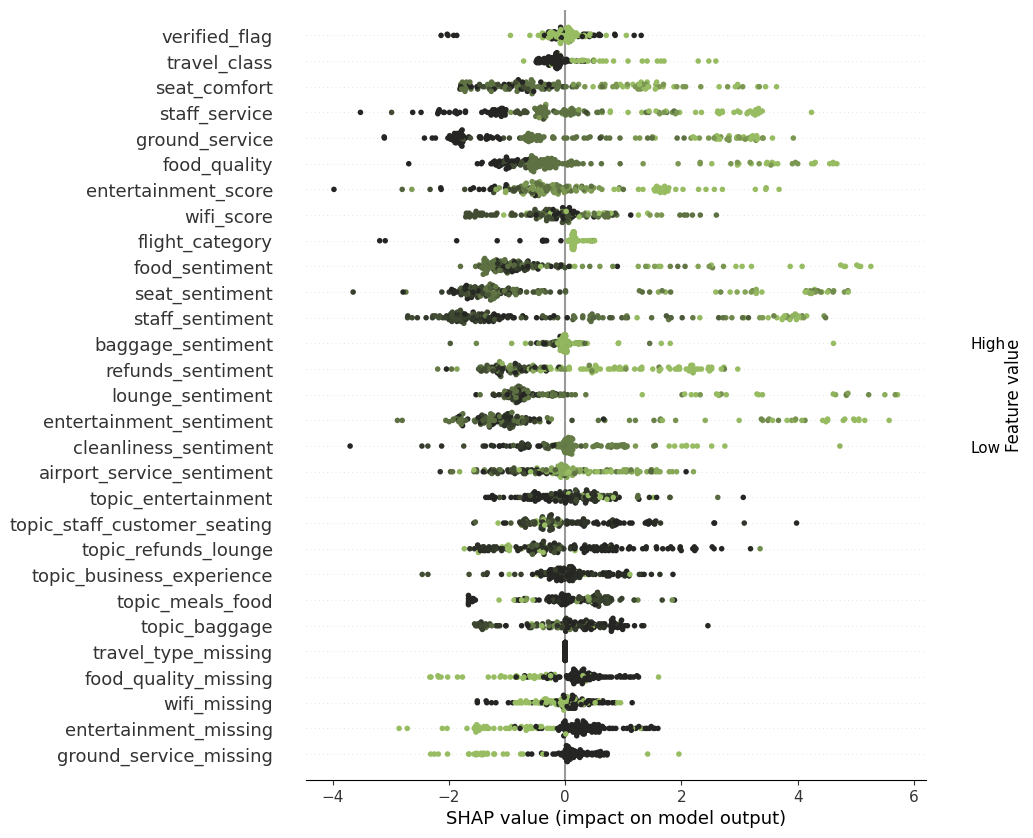

In [ ]:
# === Emirates During-COVID SHAP+ ===
shap_plus_em_during = mcr_model_em_during.mcr_shap_plot(X_em_during, mcr_plus=True, plot_size=(10,10), sort=False)

- **SHAP-Based Feature Contributions (Negative Only) – During-COVID (MCRForest Model)**

 set_estimators(self, force_use = False, var_indexs = [0], debug = True )
 set_estimators(self, force_use = False, var_indexs = [1], debug = True )
 set_estimators(self, force_use = False, var_indexs = [2], debug = True )
 set_estimators(self, force_use = False, var_indexs = [3], debug = True )
 set_estimators(self, force_use = False, var_indexs = [4], debug = True )
 set_estimators(self, force_use = False, var_indexs = [5], debug = True )
 set_estimators(self, force_use = False, var_indexs = [6], debug = True )
 set_estimators(self, force_use = False, var_indexs = [7], debug = True )
 set_estimators(self, force_use = False, var_indexs = [8], debug = True )
 set_estimators(self, force_use = False, var_indexs = [9], debug = True )
 set_estimators(self, force_use = False, var_indexs = [10], debug = True )
 set_estimators(self, force_use = False, var_indexs = [11], debug = True )
 set_estimators(self, force_use = False, var_indexs = [12], debug = True )
 set_estimators(self, force_use = F

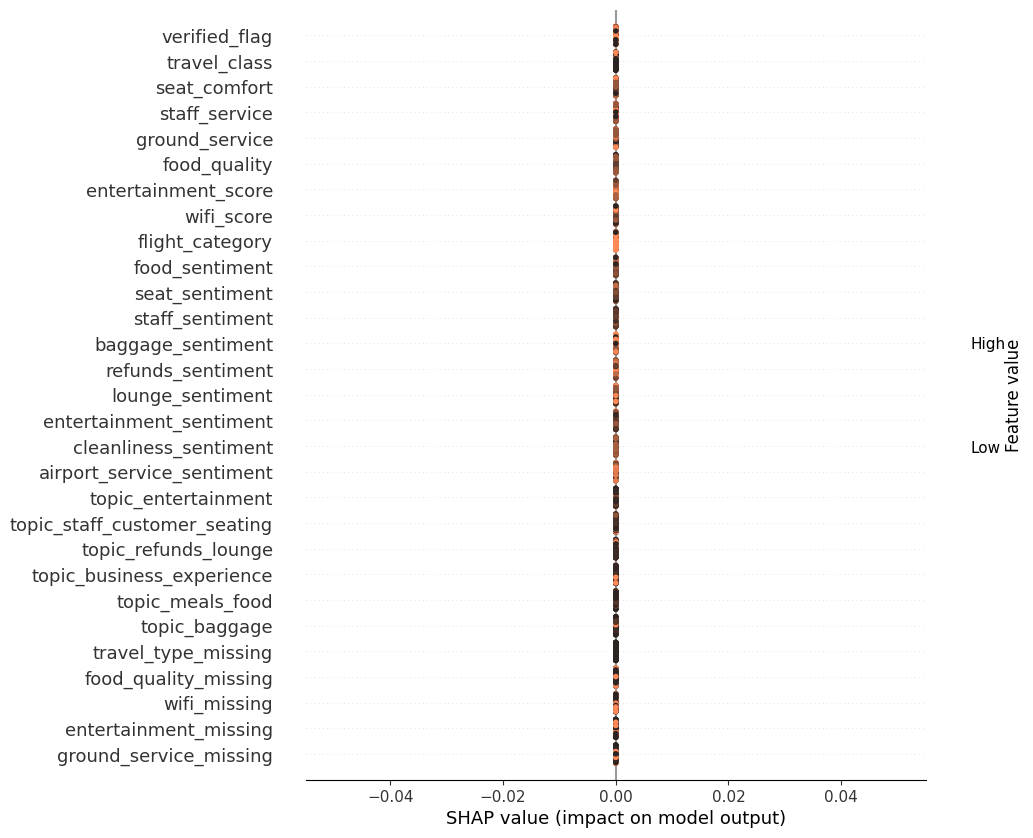

In [13]:
# === Emirates During-COVID SHAP- ===
shap_minus_em_during = mcr_model_em_during.mcr_shap_plot(X_em_during, mcr_plus=False, plot_size=(10,10), sort=False)

### A] Model Class Reliance (MCR) – Post-COVID Period


=== Emirates | Post-COVID (MCR) ===
Processing MCR+ groups of features.


100%|██████████| 29/29 [00:15<00:00,  1.90it/s]


Processing MCR- groups of features.


100%|██████████| 29/29 [00:15<00:00,  1.83it/s]


MCR+ sum: 152.3944683471075


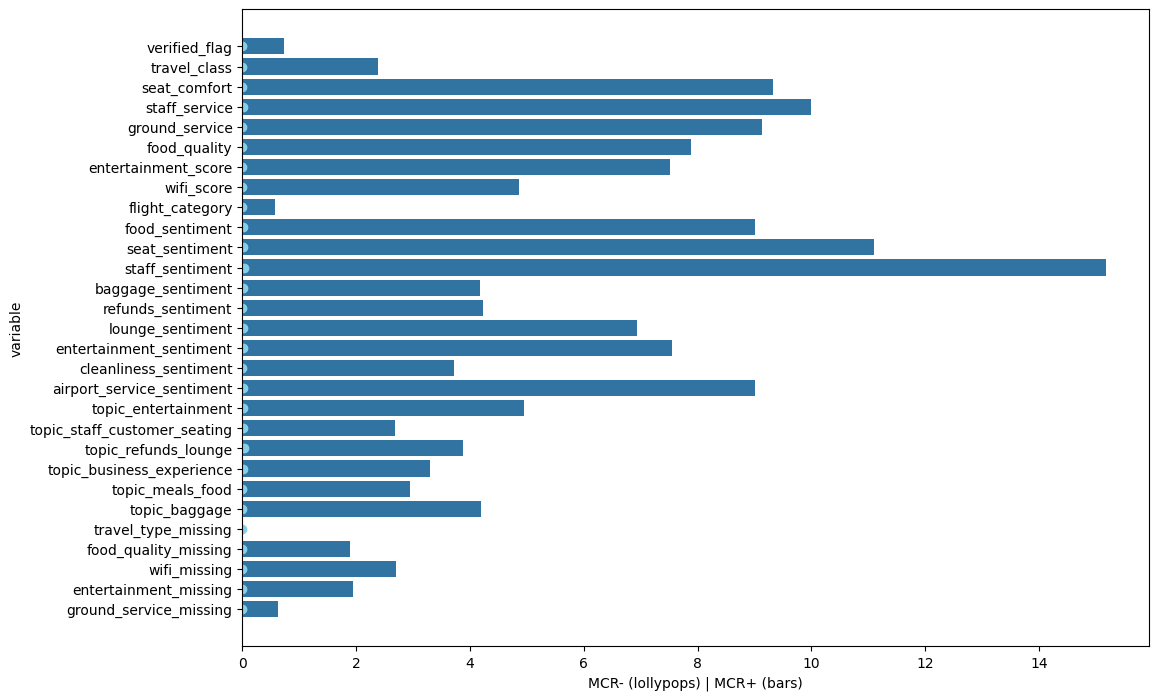

In [12]:
X_em_post, mcr_model_em_post, mcr_df_em_post = run_mcr_period(em_post, "Emirates", "Post", em_params_post)

In [13]:
import os

# Define the path to your Downloads folder
download_path = r"C:\Users\Samiksha\Downloads\mcr_df_em_post"

# Save the DataFrame as CSV to Downloads
mcr_df_em_post.to_csv(download_path, index=False)

print(f"CSV saved to: {download_path}")

CSV saved to: C:\Users\Samiksha\Downloads\mcr_df_em_post


- **SHAP-Based Feature Contributions (Positive Only) – Post-COVID (MCRForest Model)**

 set_estimators(self, force_use = True, var_indexs = [0], debug = True )
 set_estimators(self, force_use = True, var_indexs = [1], debug = True )
 set_estimators(self, force_use = True, var_indexs = [2], debug = True )
 set_estimators(self, force_use = True, var_indexs = [3], debug = True )
 set_estimators(self, force_use = True, var_indexs = [4], debug = True )
 set_estimators(self, force_use = True, var_indexs = [5], debug = True )
 set_estimators(self, force_use = True, var_indexs = [6], debug = True )
 set_estimators(self, force_use = True, var_indexs = [7], debug = True )
 set_estimators(self, force_use = True, var_indexs = [8], debug = True )
 set_estimators(self, force_use = True, var_indexs = [9], debug = True )
 set_estimators(self, force_use = True, var_indexs = [10], debug = True )
 set_estimators(self, force_use = True, var_indexs = [11], debug = True )
 set_estimators(self, force_use = True, var_indexs = [12], debug = True )
 set_estimators(self, force_use = True, var_inde

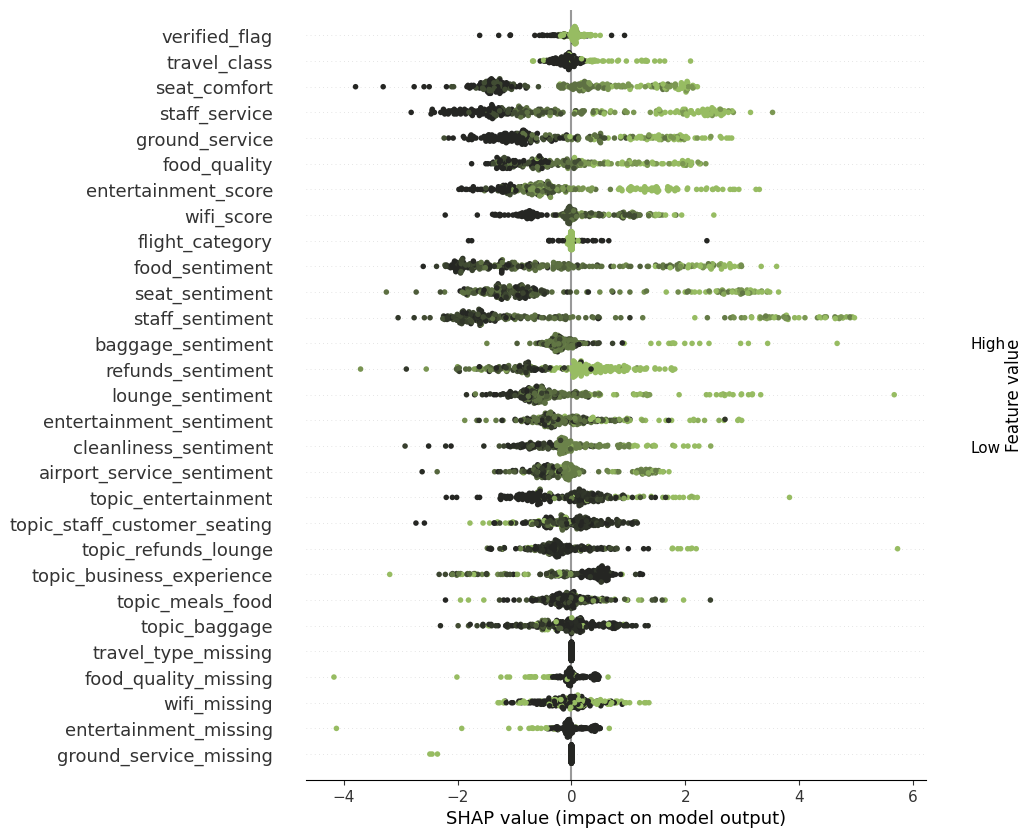

In [15]:
# === Emirates Post-COVID SHAP+ ===
shap_plus_em_post = mcr_model_em_post.mcr_shap_plot(X_em_post, mcr_plus=True, plot_size=(10,10), sort=False)

- **SHAP-Based Feature Contributions (Negative Only) – Post-COVID**

 set_estimators(self, force_use = False, var_indexs = [0], debug = True )
 set_estimators(self, force_use = False, var_indexs = [1], debug = True )
 set_estimators(self, force_use = False, var_indexs = [2], debug = True )
 set_estimators(self, force_use = False, var_indexs = [3], debug = True )
 set_estimators(self, force_use = False, var_indexs = [4], debug = True )
 set_estimators(self, force_use = False, var_indexs = [5], debug = True )
 set_estimators(self, force_use = False, var_indexs = [6], debug = True )
 set_estimators(self, force_use = False, var_indexs = [7], debug = True )
 set_estimators(self, force_use = False, var_indexs = [8], debug = True )
 set_estimators(self, force_use = False, var_indexs = [9], debug = True )
 set_estimators(self, force_use = False, var_indexs = [10], debug = True )
 set_estimators(self, force_use = False, var_indexs = [11], debug = True )
 set_estimators(self, force_use = False, var_indexs = [12], debug = True )
 set_estimators(self, force_use = F

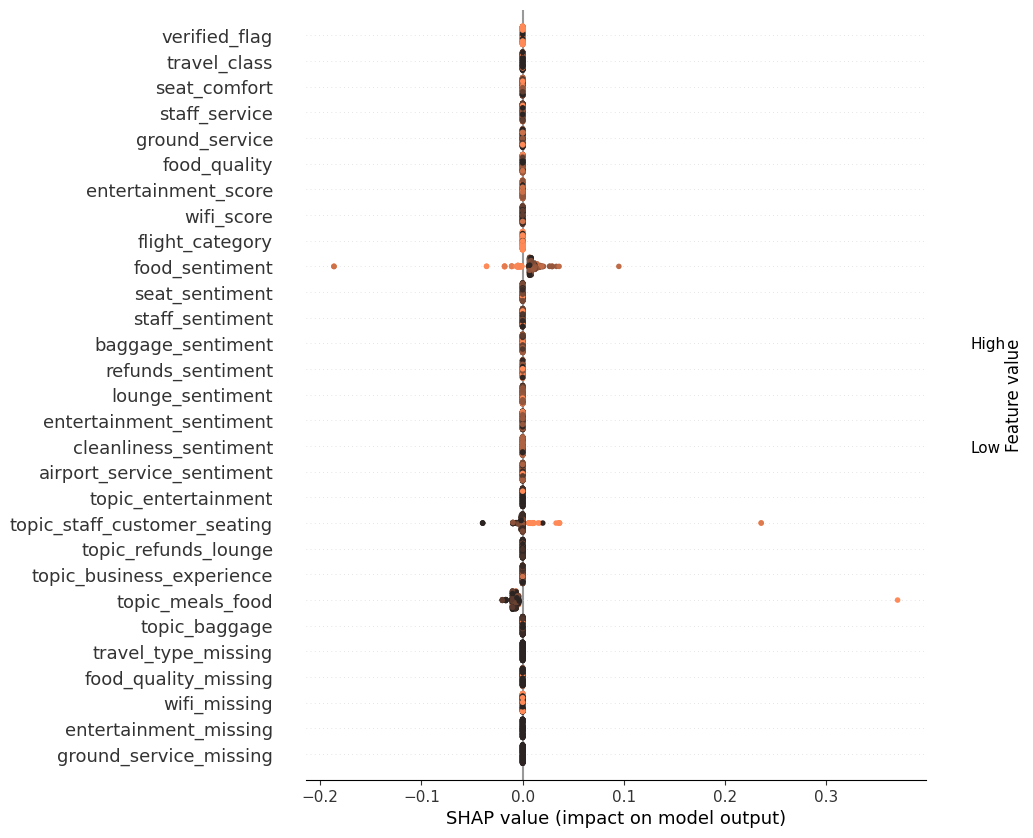

In [16]:
# === Emirates Post-COVID SHAP- ===
shap_minus_em_post = mcr_model_em_post.mcr_shap_plot(X_em_post, mcr_plus=False, plot_size=(10,10), sort=False)